In [1]:
# Libraries used:
import rebound
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import *
import os
from IPython.display import display, clear_output
from ipywidgets import IntProgress
from IPython.display import display
import time
import pandas as pd

# Algunas configuraciones generales:
plt.style.use('seaborn-whitegrid')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 19
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11

In [2]:
# K2:K1 resonance?
K2 = 3
K1 = 1
RESO = str(K2) + '-' + str(K1) # String "K2-K1"

# CASE? (angular momentum and mass ratio)
AMnorm = 0.9 #  0<AMnorm<1
m21 = 5 # = m2/m1 
# In the next cell are the planetary initial conditions

# MODES OF OPERATION (inidicated with flag MODO):
# MODO = 0 means perform integration with Rebound.
# MODO = 1 means load an integration from file.
MODO = 0

# Integration setup (only for MODO = 0):
Ttot  = 1e5   # total int. time
d_out = 1     # output step
m0    = 1     # primary mass (fixed)

# OTHER SETUP:
# If ANGLE = 0 => The angles: (0, 360). If ANGLE = 1 => The angles: (-180,180). 
ANGLE = 0
# Load numerical integration to compare it with model in other notebook?
COMPARAR = True
# Use theta instead of sigma? 
THETA = False
# Save integration data and plots (MODO = 1 only can save plots)
SAVE_data = True
SAVE_plot = True

# Directory and file names:
COMUN = "/home/juan/Escritorio/TESIS/"  # Common path
dir_data = COMUN + "PROGRAMAS/REBOUND/COPLANAR/Planetario/"+RESO+"/metodo2/m21="+str(m21)+"/AM="+str(AMnorm)+"/ACR1/"
dir_plot = dir_data
file_data1 = "planeta1.txt"
file_data2 = "planeta2.txt"

# Image format and quality (in dpi)
formato = "jpg"
cal     = 150
file_plot1 = "planeta1" +"."+ formato
file_plot2 = "planeta2" +"."+ formato
file_plot3 = "otros" +"."+ formato

In [3]:
# PLANETARY INITIAL CONDITIONS
# This notebook was designed to perform numerical integrations of resonant 2-planet systems
# and compare the results with the H-surface model (Pons & Gallardo 2022) but it can be used 
# with general purpose changing all initial elements manually at the end of this cell.
# The initial elements are: a1i, e1i, w1i (long. of peri.), l1i (mean long.), a2i, e2i, w2i, l2i. 

# Internal = 1 ; External = 2
m2 = 0.001 # fixed
m1 = m2/m21

# Initial semi-major axis:
a2i = 1 # fixed
a1i = a2i*(((K1/K2)**2)*((m0+m1)/(m0+m2)))**(1/3) # a1 is defined by resonance and masses
#a1i = 0.651925 #0.631875 # a corrected 

# AM calculation:
G = 0.01720209895**2
mu1 = G*(m1 + m0)*a1i
mu2 = G*(m2 + m0)*a2i
beta1 = m1*m0/(m1 + m0)
beta2 = m2*m0/(m2 + m0)
C1 = beta1*sqrt(mu1)
C2 = beta2*sqrt(mu2)
AM_min = 0
AM_max = C1 + C2
AM = AMnorm*AM_max   # Angular momentum

# 0.6299605249474366     0.25   0.0  0.0  0.0        0.0    180.0
# 1.0     0.873350029764019   0.0  0.0  0.0        0.0    180.0
# Planetary I.C.:
w2i = 0 # fixed
l2i = 0 # fixed
e1i = 0.51
w1i = 76.0
thetai = 0
sigmai = 104.75
# decide which resonant angle to use
if (THETA):
    s1i = thetai
else:
    s1i = sigmai 

# I.C. defined by equations:
e2i = sqrt( 1 - ((AM-C1*sqrt(1-e1i**2))/(C2))**2 )
if (THETA):
    l1i = (thetai + K2*l2i)/K1
else:
    l1i = (sigmai + K2*l2i - (K2-K1)*w1i)/K1

# MANUAL INITIAL CONDITIONS SET UP (Optional):
# a1i = 1.0
# e1i = 0.01671123
# w1i = 0.0
# l1i = 0.0
# a2i = 5.204267
# e2i = 0.04839266
# w2i = 0.0
# l2i = 0.0

# e1i,w1i and s1i (thetai or sigmai) defines name of folder to load/save data
caso_str = 'e1=%.2f_w1=%.0f_s1=%.0f' % (e1i,w1i,s1i)

dir_data = dir_data + caso_str + "/" #"_acorr/"
dir_plot = dir_plot + caso_str + "/" #"_acorr/"

print("Intitial conditions are (a, e, varpi, lambda):")
print("Planet 1:            ", round(a1i,4), round(e1i,3), " ", w1i, " ", l1i)
print("Planet 2:            ", round(a2i,4), "   ", round(e2i,3), " ", w2i, " ", l2i) 
print(" ")
print("CASO:",caso_str)

Intitial conditions are (a, e, varpi, lambda):
Planet 1:             0.4806 0.51   76.0   -47.25
Planet 2:             1     0.424   0   0
 
CASO: e1=0.51_w1=76_s1=105


In [4]:
# CONFIGURACÓN DE LA SIMULACIÓN

if (MODO == 0):
    # Creo sim
    sim = rebound.Simulation()

    # Eligo algoritmo de integración:
    # sim.integrator = "whfast"
    sim.integrator = "mercurius" 
    sim.ri_mercurius.hillfac = 4. # Hill radius for mercurius

    # Eligo el sistema de ref.:
    # sim.ri_whfast.coordinates = 'jacobi' #default
    # sim.ri_whfast.coordinates = 'democraticheliocentric' # ~ Poincare
    # sim.ri_whfast.coordinates = 'whds'
    sim.ri_mercurius.coordinates = 'democraticheliocentric'

    # Defino unidades y paso del tiempo:
    sim.units = ('yrs', 'AU', 'Msun')
    dT    = 0.001  # paso de la int.
    Nout  = int(Ttot/d_out) # puntos en la salida
    #sim.t = Ttot
    sim.dt = dT

    # Mejorar performance y accuaracy:
    # sim.ri_whfast.safe_mode = 0
    # sim.ri_whfast.corrector = 11 # Solo en Jacobi

    KG2 = sqrt(sim.G)
    #print(KG2)
    G2R = pi/180
    R2G = 180/pi

    # DEFINO OBJETOS:
    star = sim.add(m=m0)            
    pla1 = sim.add(m=m1, a=a1i, e=e1i, inc=0*G2R, pomega=w1i*G2R, Omega=0*G2R, l=l1i*G2R)
    pla2 = sim.add(m=m2, a=a2i, e=e2i, inc=0*G2R, pomega=w2i*G2R, Omega=0*G2R, l=l2i*G2R)
    # pla1 = sim.add(m=0.0000000001, a=3.2757, e=0.55, inc=0*G2R, pomega=0*G2R, Omega=0*G2R, M=0*G2R)
    # pla2 = sim.add(m=0.0001, a=5.2, e=0.3,     inc=0*G2R, pomega=0*G2R, Omega=0*G2R, M=0*G2R)

    particles = sim.particles

    sim.status()

---------------------------------
REBOUND version:     	3.19.2
REBOUND built on:    	Mar  9 2022 12:07:46
Number of particles: 	3
Selected integrator: 	mercurius
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x7f469fc8a740, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7f469fc8aec0, m=0.0002 x=0.09970625813701631 y=-0.664904687368397 z=0.0 vx=5.206365466848664 vy=2.8627340274263964 vz=0.0>
<rebound.particle.Particle object at 0x7f469fc8a740, m=0.001 x=0.5757252711742288 y=-0.00013295434660435854 z=0.0 vx=0.0010410648803936542 vy=9.889105812435346 vz=0.0>
---------------------------------


In [5]:
# INTEGRACIÓN NUMÉRICA:

# Integro con REBOUND
if (MODO == 0):   
    # Inicializo variables:
    times = np.linspace(0, Ttot, Nout)
    t1 = times
    t2 = times
    a1 = np.zeros(Nout)
    e1 = np.zeros(Nout)
    w1 = np.zeros(Nout)
    l1 = np.zeros(Nout)
    a2 = np.zeros(Nout)
    e2 = np.zeros(Nout)
    w2 = np.zeros(Nout)
    l2 = np.zeros(Nout)

    # Barra para indicar el progreso:
    print('Progress:')
    barra = IntProgress(min=0, max=Nout) # instantiate the bar
    display(barra) # display the bar

    # Integro en pasos (Ttot/Nout) y voy guardando elementos:
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        a1[i] = particles[1].a
        e1[i] = particles[1].e
        w1[i] = (particles[1].pomega)*R2G % 360
        l1[i] = (particles[1].l)*R2G % 360
        a2[i] = particles[2].a
        e2[i] = particles[2].e
        w2[i] = (particles[2].pomega)*R2G % 360
        l2[i] = (particles[2].l)*R2G % 360
        barra.value += 1 # signal to increment the progress bar

    sim.status()

# Cargo integración desde archivo:
if (MODO == 1):
    # Son 2 dataframe, uno para c/planeta
    Dint1 = pd.read_csv(dir_data + file_data1, delimiter=r"\s+")
    Dint2 = pd.read_csv(dir_data + file_data2, delimiter=r"\s+")
    # planet 1:
    t1 = Dint1['t'].values
    a1 = Dint1['a1'].values
    e1 = Dint1['e1'].values
    w1 = Dint1['w1'].values
    l1 = Dint1['lambda1'].values
    # planet 2:
    t2 = Dint2['t'].values
    a2 = Dint2['a2'].values
    e2 = Dint2['e2'].values
    w2 = Dint2['w2'].values
    l2 = Dint2['lambda2'].values
        
# Otras cantidades de interés:
deltaW = (w1-w2) % 360
theta = (K1*l1-K2*l2) % 360
s1 = (theta + (K2-K1)*w1) % 360
s2 = (theta + (K2-K1)*w2) % 360
ds = (theta + (K2-K1)*deltaW) % 360

# Acomodo ángulos:
w1 = w1 % 360
w2 = w2 % 360
l1 = l1 % 360
l2 = l2 % 360
if (ANGLE == 1):
    w1 = np.where(w1>180, w1 - 360, w1)
    l1 = np.where(l1>180, l1 - 360, l1)
    s1 = np.where(s1>180, s1 - 360, s1)
    w2 = np.where(w2>180, w2 - 360, w2)
    l2 = np.where(l2>180, l2 - 360, l2)
    s2 = np.where(s2>180, s2 - 360, s2)
    deltaW = np.where(deltaW>180, deltaW - 360, deltaW)
    theta = np.where(theta>180, theta - 360, theta)
    ds = np.where(ds>180, ds - 360, ds)
    angle_yticks = np.arange(-180,270,90)
else:
    angle_yticks = np.arange(0,450,90)

# FIN INTEGRACION NUMËRICA    

Progress:


IntProgress(value=0, max=100000)

---------------------------------
REBOUND version:     	3.19.2
REBOUND built on:    	Mar  9 2022 12:07:46
Number of particles: 	3
Selected integrator: 	mercurius
Simulation time:     	1.0000000002608393e+05
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x7f469fc8abc0, m=1.0 x=104.10651327045156 y=1044.9101116146146 z=0.0 vx=0.002904836945846782 vy=0.008405248958433498 vz=0.0>
<rebound.particle.Particle object at 0x7f469fc8af40, m=0.0002 x=103.60245629576764 y=1044.6862495319856 z=0.0 vx=6.290265469363387 vy=-4.6265273428475435 vz=0.0>
<rebound.particle.Particle object at 0x7f469fc8abc0, m=0.001 x=104.77818373928552 y=1046.0927448157372 z=0.0 vx=-3.120575881469599 vy=2.981709233916014 vz=0.0>
---------------------------------


In [6]:
# Calculate mean a1 to correct a1i (structure law)
print(a1.mean())

0.4807800050689364


/tmp/ipykernel_14196/528630128.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[0].plot(t1, a1, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/528630128.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[1].plot(t1, e1, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/528630128.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[2].plot(t1, w1, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/528630128.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[3].plot(t1, s1, 's', marker = '.', ms = 1,

Saved in: /home/juan/Escritorio/TESIS/PROGRAMAS/REBOUND/COPLANAR/Planetario/3-1/metodo2/m21=5/AM=0.9/ACR1/e1=0.51_w1=76_s1=105/planeta1.jpg


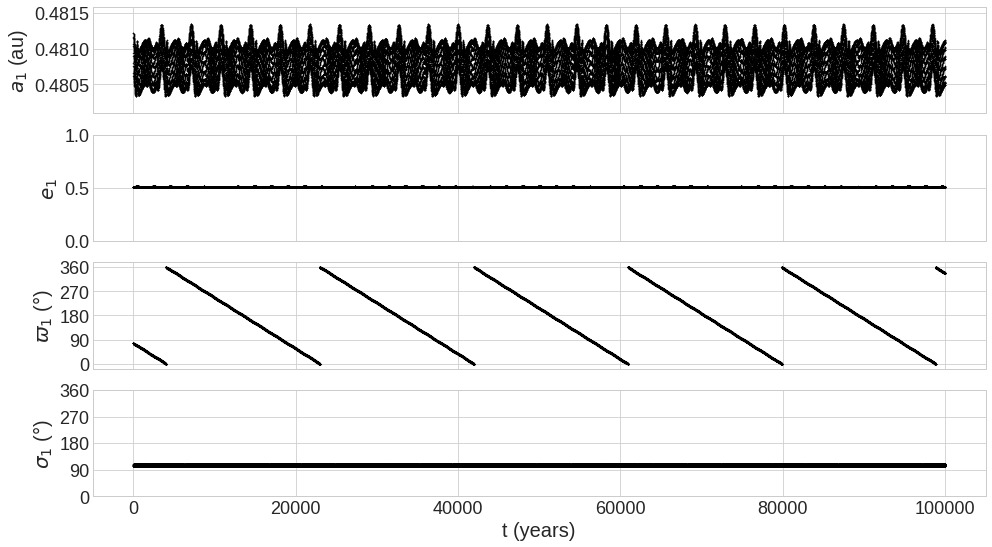

In [7]:
# GRÁFICOS PLANETA 1
fig, axs = plt.subplots(4, 1, figsize = (16, 9), sharex = 'col', sharey = False)

# Gráficos: a(t), e(t) y ángulos(t).
axs[0].plot(t1, a1, 's', marker = '.', ms = 1, c='k')
axs[1].plot(t1, e1, 's', marker = '.', ms = 1, c='k')
axs[2].plot(t1, w1, 's', marker = '.', ms = 1, c='k')
axs[3].plot(t1, s1, 's', marker = '.', ms = 1, c='k')

# Labels y ticks:
axs[0].set(ylabel = '$a_1$ (au)', ylim = [0.9995*min(a1), 1.0005*max(a1)])
axs[1].set(ylabel = '$e_1$', ylim = [0, 1], yticks = [0, 0.5 ,1])
axs[2].set(ylabel = r'$\varpi_1$ (°)', yticks = angle_yticks)
axs[3].set(ylabel = r'$\sigma_1$ (°)', xlabel = 't (years)', yticks = angle_yticks);

if (SAVE_plot):
    if not os.path.exists(dir_plot):
        os.makedirs(dir_plot)
    plt.savefig(dir_plot + file_plot1, bbox_inches = 'tight', dpi = int(cal), format = formato);  
    print('Saved in:', dir_plot + file_plot1)

plt.show();

/tmp/ipykernel_14196/1202396764.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[0].plot(t2, a2, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/1202396764.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[1].plot(t2, e2, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/1202396764.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[2].plot(t2, w2, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/1202396764.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[3].plot(t2, s2, 's', marker = '.', ms 

Saved in: /home/juan/Escritorio/TESIS/PROGRAMAS/REBOUND/COPLANAR/Planetario/3-1/metodo2/m21=5/AM=0.9/ACR1/e1=0.51_w1=76_s1=105/planeta2.jpg


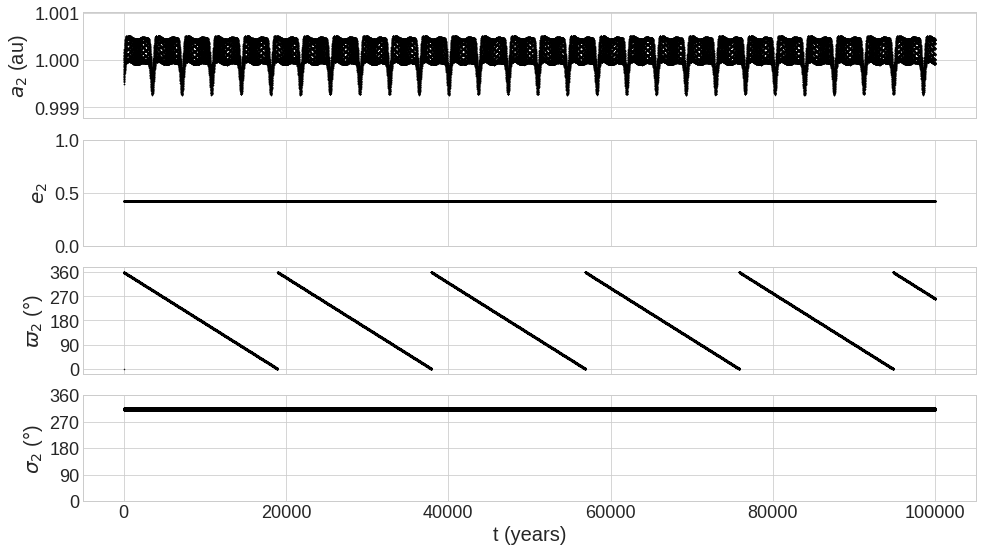

In [8]:
# GRÁFICOS PLANETA 2
fig, axs = plt.subplots(4, 1, figsize = (16, 9), sharex = 'col', sharey = False)

# Gráficos: a(t), e(t) y ángulos(t).
axs[0].plot(t2, a2, 's', marker = '.', ms = 1, c='k')
axs[1].plot(t2, e2, 's', marker = '.', ms = 1, c='k')
axs[2].plot(t2, w2, 's', marker = '.', ms = 1, c='k')
axs[3].plot(t2, s2, 's', marker = '.', ms = 1, c='k')

# Labels y ticks:
axs[0].set(ylabel = '$a_2$ (au)', ylim = [0.9995*min(a2), 1.0005*max(a2)])
axs[1].set(ylabel = '$e_2$', ylim = [0, 1], yticks = [0, 0.5 ,1])
axs[2].set(ylabel = r'$\varpi_2$ (°)', yticks = angle_yticks)
axs[3].set(ylabel = r'$\sigma_2$ (°)', xlabel = 't (years)', yticks = angle_yticks);

if (SAVE_plot):
    plt.savefig(dir_plot + file_plot2, bbox_inches = 'tight', dpi = int(cal), format = formato);  
    print('Saved in:', dir_plot + file_plot2)

plt.show();

/tmp/ipykernel_14196/2075362571.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[0].plot(t1, deltaW, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/2075362571.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[1].plot(t1, theta, 's', marker = '.', ms = 1, c='k')
/tmp/ipykernel_14196/2075362571.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  axs[2].plot(t1, ds, 's', marker = '.', ms = 1, c='k')


Saved in: /home/juan/Escritorio/TESIS/PROGRAMAS/REBOUND/COPLANAR/Planetario/3-1/metodo2/m21=5/AM=0.9/ACR1/e1=0.51_w1=76_s1=105/otros.jpg


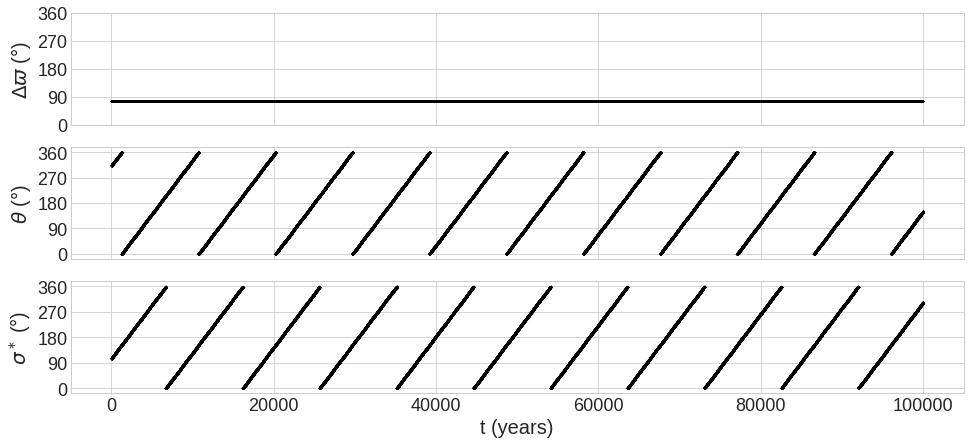

In [9]:
# OTROS GRÁFICOS
fig, axs = plt.subplots(3, 1, figsize = (16, 7), sharex = 'col', sharey = False)

# Gráficos: a(t), e(t) y ángulos(t).
axs[0].plot(t1, deltaW, 's', marker = '.', ms = 1, c='k')
axs[1].plot(t1, theta, 's', marker = '.', ms = 1, c='k')
axs[2].plot(t1, ds, 's', marker = '.', ms = 1, c='k')

# Labels y ticks:
axs[0].set(ylabel = r'$\Delta\varpi$ (°)', yticks = angle_yticks)
axs[1].set(ylabel = r'$\theta$ (°)', yticks = angle_yticks)
axs[2].set(ylabel = r'$\sigma^*$ (°)', xlabel = 't (years)', yticks = angle_yticks);

if (SAVE_plot):
    plt.savefig(dir_plot + file_plot3, bbox_inches = 'tight', dpi = int(cal), format = formato);  
    print('Saved in:', dir_plot + file_plot3)

plt.show();

In [10]:
if ((SAVE_data) and (MODO == 0)):
    if not os.path.exists(dir_data):
         os.makedirs(dir_data)
    formato = "%6.2f %8.6f %8.6f %5.2f %5.2f"
    nom_cols1 = "    t    a1       e1      w1  lambda1"
    nom_cols2 = "    t    a2       e2      w2  lambda2"
    data1 = np.c_[t1, a1, e1, w1, l1]
    data2 = np.c_[t2, a2, e2, w2, l2]
    np.savetxt(dir_data + file_data1, data1, fmt=formato, header = nom_cols1, comments='')
    np.savetxt(dir_data + file_data2, data2, fmt=formato, header = nom_cols2, comments='')
    print('Saved in:', dir_data)
        
# Para levantar en otro notebook:    
if (COMPARAR):
    %store e1
    %store deltaW
    %store s1
# del e1 
# del deltaW 
# del sigma2

Saved in: /home/juan/Escritorio/TESIS/PROGRAMAS/REBOUND/COPLANAR/Planetario/3-1/metodo2/m21=5/AM=0.9/ACR1/e1=0.51_w1=76_s1=105/
Stored 'e1' (ndarray)
Stored 'deltaW' (ndarray)
Stored 's1' (ndarray)


In [11]:
# FIN DEL PROGRAMA